### Participate in the design of an autonomous car

**In this notebook we will only consider the Oxford  Xception model developed by F. Chollet. We will test the model under the loss fuction balanced cross entropy and dice loss and compare their performances.**

In [ ]:
# Import the libraies
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
import six
from collections import namedtuple
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout
from tensorflow.keras.layers import concatenate,BatchNormalization, UpSampling2D, SeparableConv2D, add, Activation, Conv2DTranspose
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from imgaug import augmenters as iaa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Paths to the G-Drive

In [ ]:
model_path = '/content/drive/MyDrive/P08/models'
checkpoint_path='/content/drive/MyDrive/P08/checkpoints'
train_input_dir = '/content/drive/MyDrive/P08/train/images'
train_mask_dir = '/content/drive/MyDrive/P08/train/masks30'
train_target_dir = '/content/drive/MyDrive/P08/train/masks'
val_input_dir = '/content/drive/MyDrive/P08/val/images'
val_mask_dir = '/content/drive/MyDrive/P08/val/masks30'
val_target_dir = '/content/drive/MyDrive/P08/val/masks'
test_input_dir = '/content/drive/MyDrive/P08/test/images'
test_mask_dir = '/content/drive/MyDrive/P08/test/masks30'
test_target_dir = '/content/drive/MyDrive/P08/test/masks'

In [ ]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of masks in 8 categories: ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('VAL -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of masks in 8 categories: ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TEST -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of masks in 8 categories: ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2400  - Number of original masks:  2400  - Number of masks in 8 categories:  2400
/content/drive/MyDrive/P08/train/images/aachen_000000_000019.png

VAL -- Number of images:  575  - Number of original masks:  575  - Number of masks in 8 categories:  575
/content/drive/MyDrive/P08/val/images/stuttgart_000124_000019.png

TEST -- Number of images:  500  - Number of original masks:  500  - Number of masks in 8 categories:  500
/content/drive/MyDrive/P08/test/images/frankfurt_000000_000294.png


#### Create a dataframe to compare the models

In [ ]:
model_result=pd.DataFrame(columns=['model_name','epochs','training_time', 'eval_time','accuracy',
                                   'val_accuracy', 'mean_IoU','val_mean_IoU'])

#### We will utilise two loss functions dice and balanced cross entropy.

#### Dice Loss

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)

    numerator = 2 * tf.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.reduce_sum(y_true + y_pred) + smooth

    return 1 - numerator / denominator

#### Balanced Cross Entropy

In [ ]:
beta=0.5

def balanced_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
    return tf.reduce_mean(o)

  return loss

#### Hyperparameters for the model

Now we define the hyperparameters for the model.



In [ ]:
img_height, img_width = 256, 512
img_size = (img_height, img_width)
batch_size = 20
n_classes = 8
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mean_IoU = tf.keras.metrics.MeanIoU(num_classes=8, name='mean_IoU')
epochs = 10

In [ ]:
from collections import namedtuple

# Adaptation from the official Cityscapes scripts
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#--------------------------------------------------------------------------------
# Definitions : 
#--------------------------------------------------------------------------------
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

# Function to map labels and categories
def map_id2category(labels):
    """ This function maps the ~30 labels' IDs
        to the 8 main categories' IDs
    """
    cat_label = {label.id: label.categoryId for label in labels}
    
    # Get the mapping
    map_category = np.vectorize(cat_label.get)
    return map_category

#### Define the sequence generator

In [ ]:
class seg_gen(Sequence):
    """Create the data generator
    """

    # ==== Initialize the class ==== #
    def __init__(self, input_path, target_path, img_size, batch_size, 
                 labels, n_classes, shuffle):
        self.input_path = input_path
        self.target_path = target_path
        self.targetSize = img_size
        self.batch_size = batch_size
        self.labels = labels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()


    # ==== Set the number of batches per epoch ==== #
    def __len__(self):
        return int(np.floor(len(self.input_path) / float(self.batch_size)))
    
    
    # ==== Call a method at the end of each epoch ==== #
    def on_epoch_end(self):
        # [0,1,2,3,4... nb_image]
        self.indexes = np.arange(len(self.input_path))
        
        # [2,4,1,3,0... nb_image]
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    # ==== Get batches of images & masks ==== #
    def __getitem__(self, index):
       # Genere batch_size numbers d'ID of row of DATA (batch_size=2, [0,1])
       currentBatchIdsRow = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    
       batch_x, batch_y = [], []
    
       # Iterate over indexes
       for i, rowId in enumerate(currentBatchIdsRow):
           # Load image, set target size, convert to array, normalize
           image = img_to_array(
               load_img(f'{self.input_path[i]}', 
                        target_size=img_size))/255.
           batch_x.append(image)

           # Load original mask, set target size and convert to array
           mask8 = img_to_array(
               load_img(f'{self.target_path[i]}', color_mode = "grayscale", 
                        target_size=img_size))
           
           # Load 8 main categories
           mask = to_categorical(mask8, self.n_classes)                   
           batch_y.append(mask)
     
       return np.array(batch_x), np.array(batch_y)

In [ ]:
# Generate data
train_gen = seg_gen(train_input_path, train_target_path, img_size, 
                         batch_size, labels, n_classes, shuffle=False)
val_gen = seg_gen(val_input_path, val_target_path, img_size, 
                       batch_size, labels, n_classes, shuffle=False)
test_gen = seg_gen(test_input_path, test_target_path, img_size, 
                       batch_size, labels, n_classes, shuffle=False)

In [ ]:
len(train_gen), len(val_gen), len(test_gen)

(120, 28, 25)

### Create a simple Xception model

In [ ]:
# Create a Xception model (F Chollet)
def xception_model(img_size, num_classes):
    inputs = Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    x = Dropout(0.5)(x)
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    

    # Define the model
    model = Model(inputs, outputs)
    return model

### Now we use this model using the loss function balanced cross entropy.

In [ ]:
model_name= 'xception_bent'

model = xception_model(img_size, n_classes)   
model.compile(optimizer=optimizer, 
              loss=balanced_cross_entropy(beta),
              metrics=[mean_IoU, 'accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

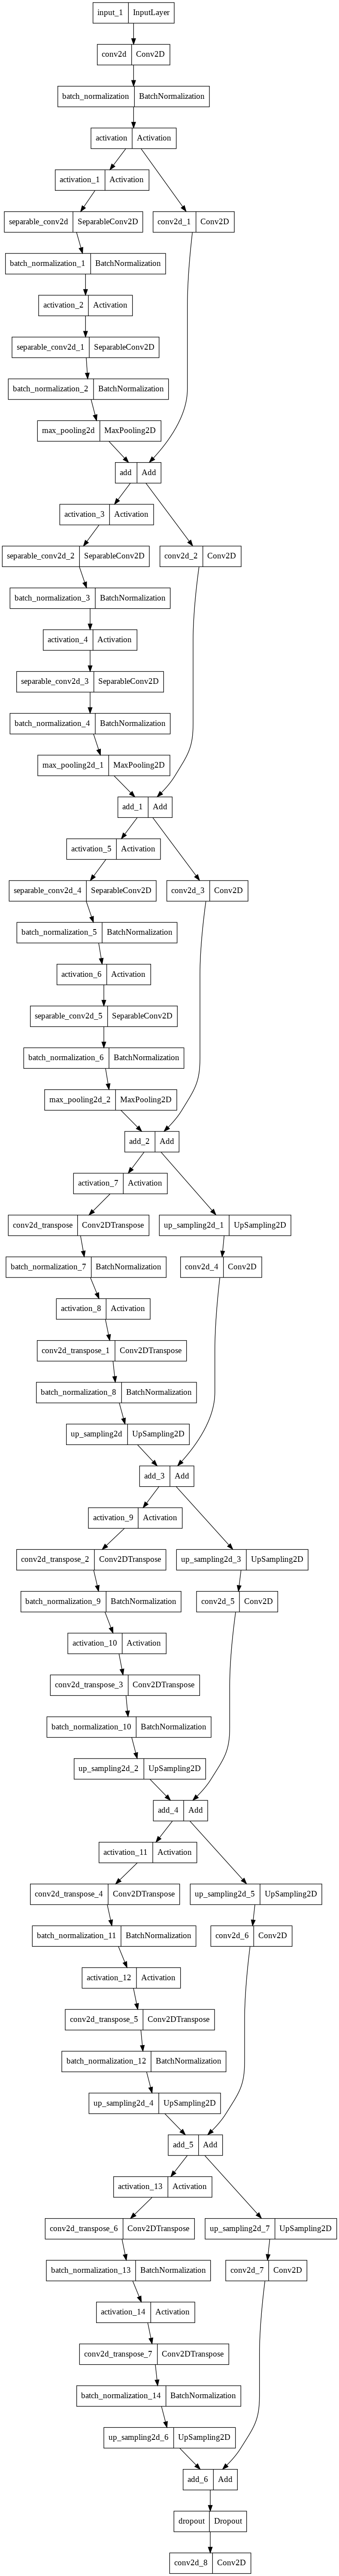

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

history=model.fit(train_gen, 
                    epochs=epochs,
                    validation_data = val_gen,
                    callbacks=callbacks)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

Training for xception_bent
Epoch 1/10
120/120 [==============================] - 379s 3s/step - loss: 0.3347 - mean_IoU: 0.8075 - accuracy: 0.8088 - val_loss: 0.3606 - val_mean_IoU: 0.4336 - val_accuracy: 0.3952
Epoch 2/10
120/120 [==============================] - 326s 3s/step - loss: 0.3273 - mean_IoU: 0.8958 - accuracy: 0.9288 - val_loss: 0.3602 - val_mean_IoU: 0.4425 - val_accuracy: 0.3999
Epoch 3/10
120/120 [==============================] - 324s 3s/step - loss: 0.3255 - mean_IoU: 0.9191 - accuracy: 0.9579 - val_loss: 0.3602 - val_mean_IoU: 0.5530 - val_accuracy: 0.4002
Epoch 4/10
120/120 [==============================] - 324s 3s/step - loss: 0.3247 - mean_IoU: 0.9323 - accuracy: 0.9696 - val_loss: 0.3600 - val_mean_IoU: 0.5530 - val_accuracy: 0.4041
Epoch 5/10
120/120 [==============================] - 325s 3s/step - loss: 0.3243 - mean_IoU: 0.9413 - accuracy: 0.9761 - val_loss: 0.3522 - val_mean_IoU: 0.6197 - val_accuracy: 0.5265
Epoch 6/10
120/120 [============================

In [ ]:
# Function to plot the learning curve
def plot_graphs(history):
    plt.figure(figsize=(20,4))
    
    plt.subplot(131)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'])
    
    plt.subplot(132)
    plt.plot(history.history['mean_IoU'])
    plt.plot(history.history['val_mean_IoU'])
    plt.xlabel('Epochs')
    plt.ylabel('mean_IoU')
    plt.legend(['mean_IoU', 'val_mean_IoU'])
    plt.show()

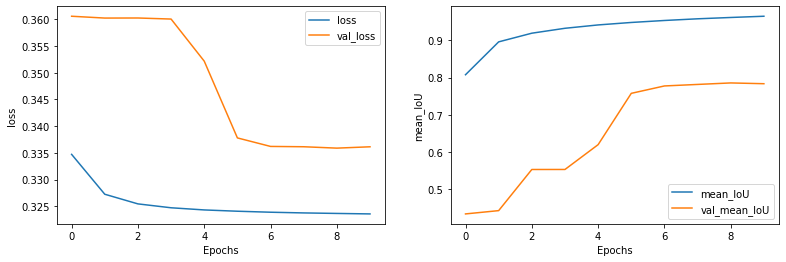

In [ ]:
 plot_graphs(history)

In [ ]:
# Evaluate the model
start_eval = time()
pred = model.predict(test_gen)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

25/25 [==============================] - 53s 2s/step
Evaluation time : 123.03474068641663


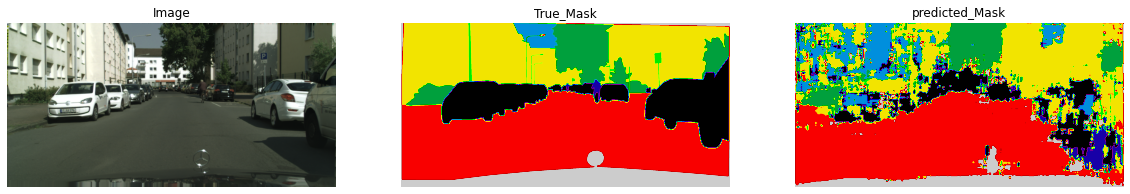

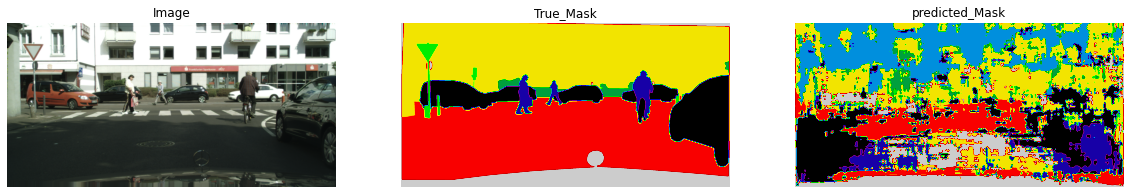

In [ ]:
for i in range(1,3):
    image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
    mask = img_to_array(load_img(f'{test_target_path[i]}', color_mode = "grayscale"))
    mask = np.squeeze(mask)
    pred_mask = np.argmax(pred[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)


    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(image)
    ax.axis('off')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('True_Mask')
    ax2.imshow(mask, cmap='nipy_spectral_r')
    ax2.axis('off')

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('predicted_Mask')
    ax1.imshow(pred_mask, cmap='nipy_spectral_r')
    ax1.axis('off')

In [ ]:
model_result = model_result.append(
        pd.Series(data={'model_name': model_name,
                        'epochs':epochs,
                        'training_time': time() - start,
                        'eval_time': time() - start_eval,
                        'accuracy': max(history.history['accuracy']),
                        'val_accuracy': max(history.history['val_accuracy']),
                        'mean_IoU' : max(history.history['mean_IoU']),
                        'val_mean_IoU' : max(history.history['val_mean_IoU'])}),
                        ignore_index=True)

In [ ]:
model_result

,model_name,epochs,training_time,eval_time,accuracy,val_accuracy,mean_IoU,val_mean_IoU
0,xception_bent,10,3583.01246,125.445884,0.987995,0.789542,0.964634,0.785479


### Now  try the same model with dice loss.

In [ ]:
model_name= 'xception_dice'

model = xception_model(img_size, n_classes)   
model.compile(optimizer=optimizer, 
              loss=dice_loss,
              metrics=[mean_IoU, 'accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 256, 32  128        ['conv2d_9[0][0]']               
 ormalization)                  )                                                           

In [ ]:
print(f'Training for {model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

history=model.fit(train_gen, 
                    epochs=epochs,
                    validation_data = val_gen,
                    callbacks=callbacks)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/{model_name}.h5')

Training for xception_dice
Epoch 1/10
120/120 [==============================] - 331s 3s/step - loss: 0.7412 - mean_IoU: 0.7790 - accuracy: 0.7653 - val_loss: 0.7730 - val_mean_IoU: 0.5458 - val_accuracy: 0.4055
Epoch 2/10
120/120 [==============================] - 327s 3s/step - loss: 0.7347 - mean_IoU: 0.8380 - accuracy: 0.8394 - val_loss: 0.7724 - val_mean_IoU: 0.5519 - val_accuracy: 0.4125
Epoch 3/10
120/120 [==============================] - 327s 3s/step - loss: 0.7330 - mean_IoU: 0.8544 - accuracy: 0.8588 - val_loss: 0.7733 - val_mean_IoU: 0.5490 - val_accuracy: 0.4026
Epoch 4/10
120/120 [==============================] - 328s 3s/step - loss: 0.7347 - mean_IoU: 0.8373 - accuracy: 0.8387 - val_loss: 0.7674 - val_mean_IoU: 0.5820 - val_accuracy: 0.4694
Epoch 5/10
120/120 [==============================] - 330s 3s/step - loss: 0.7335 - mean_IoU: 0.8498 - accuracy: 0.8528 - val_loss: 0.7685 - val_mean_IoU: 0.5757 - val_accuracy: 0.4571
Epoch 6/10
120/120 [============================

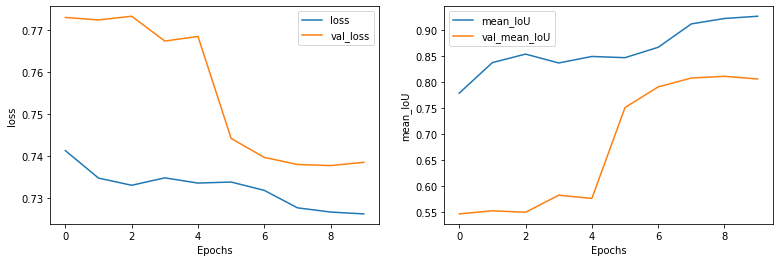

In [ ]:
 plot_graphs(history)

#### Evaluate the Xception-model

In [ ]:
start_eval = time()
pred = model.predict(test_gen)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

25/25 [==============================] - 53s 2s/step
Evaluation time : 58.16444373130798


#### Plot the model and the outputs

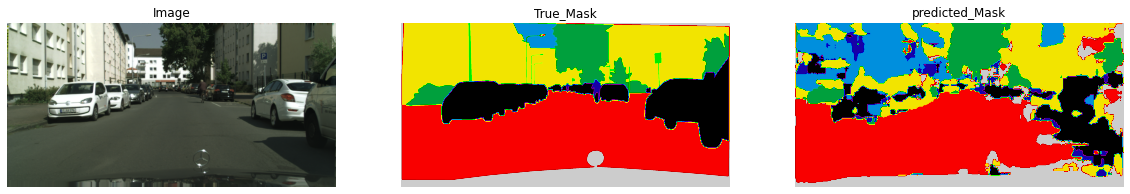

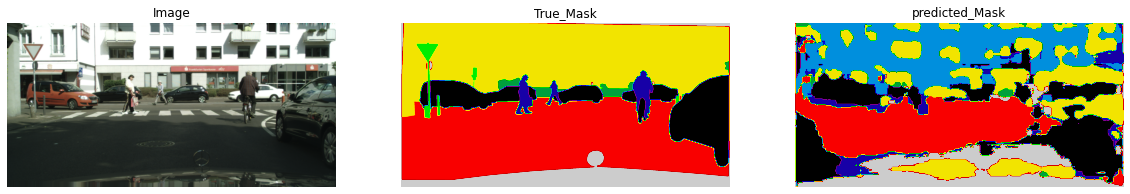

In [ ]:
for i in range(1,3):
    image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
    mask = img_to_array(load_img(f'{test_target_path[i]}', color_mode = "grayscale"))
    mask = np.squeeze(mask)
    pred_mask = np.argmax(pred[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)


    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(image)
    ax.axis('off')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('True_Mask')
    ax2.imshow(mask, cmap='nipy_spectral_r')
    ax2.axis('off')

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('predicted_Mask')
    ax1.imshow(pred_mask, cmap='nipy_spectral_r')
    ax1.axis('off')


In [ ]:
model_result = model_result.append(
        pd.Series(data={'model_name': model_name,
                        'epochs':epochs,
                        'training_time': time() - start,
                        'eval_time': time() - start_eval,
                        'accuracy': max(history.history['accuracy']),
                        'val_accuracy': max(history.history['val_accuracy']),
                        'mean_IoU' : max(history.history['mean_IoU']),
                        'val_mean_IoU' : max(history.history['val_mean_IoU'])}),
                        ignore_index=True)

#### Comparison of the model with respect of balanced cross entropy and dice loss.

In [ ]:
model_result

,model_name,epochs,training_time,eval_time,accuracy,val_accuracy,mean_IoU,val_mean_IoU
0,xception_bent,10,3583.012460,125.445884,0.987995,0.789542,0.964634,0.785479
1,xception_dice,10,3440.743234,60.405187,0.936084,0.805579,0.927472,0.811510
